In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [35]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [31]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [32]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\yama2\AppData\Local\Temp\ipykernel_10280\2639776237.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [33]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23',)

In [11]:
 # Collect the names of tables within the database
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


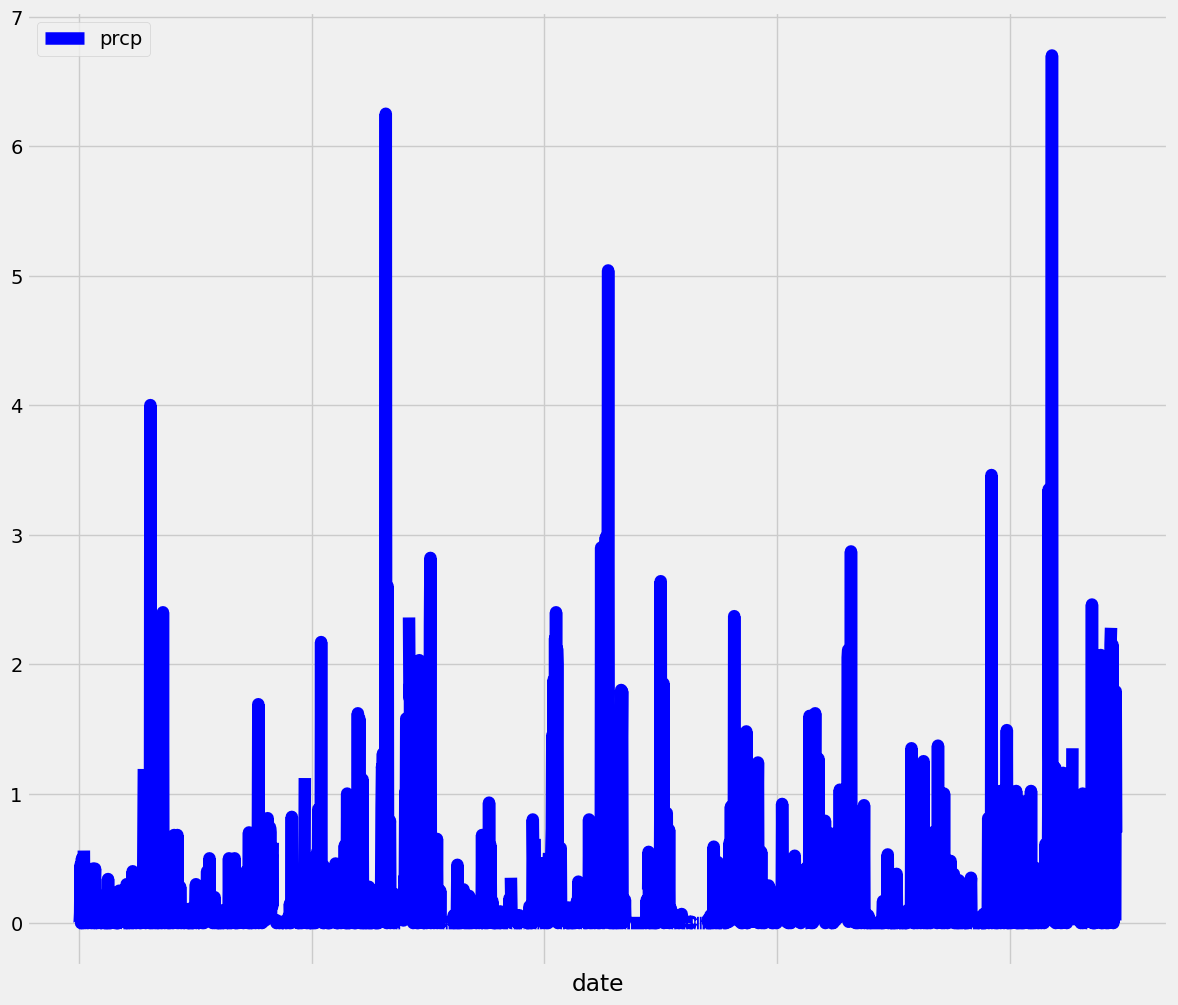

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
str_date=list(np.ravel(latest_date))[0]
start_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=start_date-dt.timedelta(days=366)


query_date = session.query(Measurement.date).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date.desc()).all()
# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date  > year_back).\
    order_by(Measurement.date.desc()).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(prcp_query, columns=['date', 'prcp'])
# Sort the dataframe by date
precipitation_df.sort_values(by=['date'], ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
ax=precipitation_df.plot(color='b',figsize=(12,10),legend=True,linewidth=9.0,grid=True)
#Removing xticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.xlabel("date")
plt.show()

In [44]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Measurement).group_by(Measurement.station).count()
station_count

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()
station

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_tobs = session.query(func.min(Measurement.tobs),
                         func.max(Measurement.tobs),
                         func.avg(Measurement.tobs)).\
    filter(Measurement.station == station[0][0]).all()
station_tobs

[(53.0, 87.0, 71.61596766043456)]

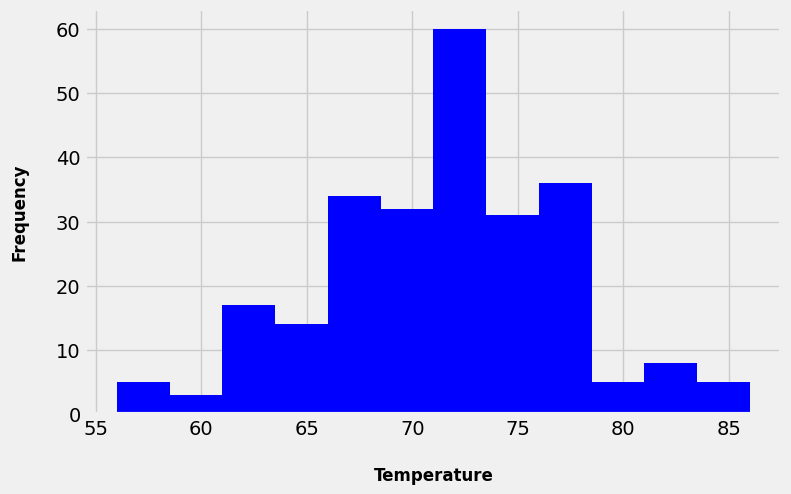

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
first_date = session.query(Measurement.date).order_by(Measurement.date.desc()).\
             filter(Measurement.station == station[0][0]).first()
str_date = list(np.ravel(first_date))[0]
latest_date = dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back = latest_date-dt.timedelta(days=366)

results_temp = session.query(Measurement.tobs).\
             filter(Measurement.station == station[0][0]).\
             filter(Measurement.date>=year_back).all()
results_df =pd.DataFrame(results_temp)

hist = results_df['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2)

# Set y-axis label
hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)
hist.set_xlabel("Temperature", labelpad=20, weight='bold', size=12)

plt.show()

# Close Session

In [50]:
# Close Session
session.close()